# 1. 로드 및 전처리 

In [37]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import xgboost as xgb
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# -------------------------
# 데이터 로드
# -------------------------
df = pd.read_csv('univ355.csv')

# -------------------------
# 결측치 컬럼 제거
# -------------------------
drop_missing_cols = [
    'why_not_rechoice', 'future_job_desc', 'income_class', 'income_contest',
    'income_perf', 'income_broadcast', 'income_studio', 'income_creator',
    'income_choreo', 'info_dept', 'info_career_center', 'info_online',
    'info_family', 'info_friends', 'info_academy', 'info_self',
    'help_financial', 'help_resume', 'help_career', 'help_social',
    'help_no', 'non_stay_reason', 'total_univ'
]
df = df.drop(columns=drop_missing_cols, errors='ignore')

# -------------------------
# current_area 관련 변수 제거
# -------------------------
current_area_cols = [col for col in df.columns if col.startswith('current_area')]
df = df.drop(columns=current_area_cols, errors='ignore')

# -------------------------
# 오타 수정
# -------------------------
if 'birth_area' in df.columns:
    df['birth_area'] = df['birth_area'].replace({'g': 'gangwon'})  # 'g' -> 'gangwon'

# -------------------------
# 범주형 변수 매핑 및 원-핫 인코딩
# -------------------------
# dance_years 매핑
midpoint_map = {'less2':1, '2to4':2, '4to7':3, '7to10':4, 'over10':5}
if 'dance_years' in df.columns:
    df['dance_years'] = df['dance_years'].map(midpoint_map)

# 원-핫 인코딩
columns_to_encode = [
    'univ_factor', 'major_factor', 'job_region', 'weight_control',
    'birth_area', 'housing_type', 'enter_type',
    'major_detail', 'univ_name', 'univ_area'
]
df = pd.get_dummies(df, columns=columns_to_encode, drop_first=True, dtype=float)

# -------------------------
# 분석 제외 변수 제거
# -------------------------
remove_vars = ["prof_hi", "int_major", "enter_year"]
df = df.drop(columns=remove_vars, errors='ignore')

# -------------------------
# 상관계수 높은 변수 사전 삭제 (전처리 단계)
# -------------------------
high_corr_remove = ['lecture_qual', 'peer_personal', 'enjoy_major', 'prof_chat','peer_study']
df = df.drop(columns=high_corr_remove, errors='ignore')


# -------------------------
# sat 변수 생성 및 이진 분류
# -------------------------
sat_cols = ['univ_proud', 'univ_belong', 'major_proud', 'major_belong']
df['sat'] = df[sat_cols].mean(axis=1)
sat_median = df['sat'].median()
df['sat_group'] = (df['sat'] >= sat_median).astype(int)

# -------------------------
# 설명용 출력
# -------------------------
print("✅ 최종 데이터셋 컬럼 수:", df.shape[1])
print("sat 중위수:", sat_median)
print(df[['sat', 'sat_group']].head())


✅ 최종 데이터셋 컬럼 수: 168
sat 중위수: 4.0
    sat  sat_group
0  4.00          1
1  4.50          1
2  3.00          0
3  3.00          0
4  4.75          1


# 2. 변수선택 파이프라인 

In [39]:
# ======================================
# ✅ 파이프라인 기반: ElasticNet + RFECV(LR/DT/RF/XGB)
#    - 변수선택은 항상 훈련 데이터(=X_train) 내부에서만 수행
#    - 폴드별 선택 변수 -> 교집합(안정적 변수) 추출
#    - CV(파이프라인 전체) & Hold-out 평가
# ======================================

import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score,
                             roc_auc_score)
import warnings
warnings.filterwarnings("ignore")

# ------------- 설정 -------------
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# (사용자 환경에 이미 df, X, y, X_train, X_test... 이 있다면 아래에서 재정의하지 않음.
#  없으면 간단하게 재생성 — 여기에선 df가 이미 전처리 끝났다는 전제)
try:
    df  # if df exists, do nothing
except NameError:
    raise RuntimeError("데이터프레임 df가 존재하지 않습니다. 먼저 전처리 셀을 실행하세요.")

# 타깃/설명변수 설정 (기존 전처리 셀에서 이미 만들어두었다면 동일하게 사용)
target_col = 'sat_group'
drop_cols = ['id','univ_proud','univ_belong','major_proud','major_belong','sat','sat_group']
X = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')
y = df[target_col].copy()

# 학습/테스트 분할 (이 분할에서 X_train에 대해서만 변수선택이 일어나도록 설계)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# CV fold 설정
inner_cv_n_splits = 5   # RFECV 내부/ENet 내부용 (if needed)
outer_cv_n_splits = 5   # cross_validate (파이프라인 전체의 CV)
inner_cv = StratifiedKFold(n_splits=inner_cv_n_splits, shuffle=True, random_state=RANDOM_STATE)
outer_cv = StratifiedKFold(n_splits=outer_cv_n_splits, shuffle=True, random_state=RANDOM_STATE)

# 성능 지표 (cross_validate에서 사용)
scoring = {"accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"}

# ------------- 파이프라인 정의 -------------
# NOTE:
# - RFECV 내부에서 추가적인 CV가 돌아가므로 RFECV의 n_jobs는 1로 설정하여
#   중첩 병렬(nested parallel)로 인한 오류/충돌을 피합니다.
# - 전체 cross_validate에서 n_jobs=-1로 병렬 처리를 하도록 하면 fold 간 병렬화가 이루어짐.

# ElasticNet: Pipeline (StandardScaler -> LogisticRegressionCV)
enet_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegressionCV(
        Cs=10, cv=inner_cv, penalty="elasticnet", solver="saga",
        l1_ratios=[0.5], scoring="f1", max_iter=5000,
        random_state=RANDOM_STATE, n_jobs=-1  # inner CV parallel
    ))
])

# RFECV pipelines: estimator inside RFECV + final classifier (same type)
# Use n_jobs=1 inside RFECV to avoid nested parallel issues.
def make_rfecv_pipeline(base_estimator, final_estimator=None, name="est"):
    if final_estimator is None:
        final_estimator = base_estimator
    rfecv = RFECV(
        estimator=base_estimator,
        step=1,
        cv=inner_cv,
        scoring='f1',
        min_features_to_select=5,
        n_jobs=1,  # IMPORTANT: RFECV's internal parallel set to 1 (safer)
        verbose=0
    )
    pipe = Pipeline([
        ("feature_selection", rfecv),
        ("clf", final_estimator)
    ])
    return pipe

rfecv_lr_pipeline = make_rfecv_pipeline(LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE),
                                        LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE),
                                        name='LR')

rfecv_dt_pipeline = make_rfecv_pipeline(DecisionTreeClassifier(random_state=RANDOM_STATE),
                                        DecisionTreeClassifier(random_state=RANDOM_STATE),
                                        name='DT')

rfecv_rf_pipeline = make_rfecv_pipeline(RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=1),
                                        RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=1),
                                        name='RF')

rfecv_xgb_pipeline = make_rfecv_pipeline(XGBClassifier(n_estimators=200, random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss', n_jobs=1),
                                         XGBClassifier(n_estimators=200, random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss', n_jobs=1),
                                         name='XGB')

models = {
    "ElasticNet": enet_pipeline,
    "RFECV_LR": rfecv_lr_pipeline,
    "RFECV_DT": rfecv_dt_pipeline,
    "RFECV_RF": rfecv_rf_pipeline,
    "RFECV_XGB": rfecv_xgb_pipeline
}

# ------------- 폴드별 선택 변수 추출 (X_train 내부에서만 수행) -------------
# - 각 모델에 대해 outer_cv (여기서는 outer_cv 대신 동일한 KFold를 사용하여)
#   X_train의 각 폴드(학습 부분)에서 변수선택을 수행하고, 해당 fold에서 선택된 변수 집합을 저장.
# - 주의: RFECV는 내부에서 다시 CV를 돌리므로 시간 많이 걸립니다.
print(">>> 폴드별 선택 변수(각 모델) 계산 (주의: RFECV는 시간이 오래 걸릴 수 있음) ...")
selected_per_model = {}   # model_name -> list of sets (len = outer_cv_n_splits)
for name, pipe in models.items():
    fold_sets = []
    for fold_idx, (tr_idx, val_idx) in enumerate(outer_cv.split(X_train, y_train)):
        X_tr_fold = X_train.iloc[tr_idx]
        y_tr_fold = y_train.iloc[tr_idx]

        if name == "ElasticNet":
            # ElasticNet: fit LogisticRegressionCV on train-fold, take non-zero coefs
            enet_fold = LogisticRegressionCV(
                Cs=10, cv=inner_cv, penalty="elasticnet", solver="saga",
                l1_ratios=[0.5], scoring="f1", max_iter=5000,
                random_state=RANDOM_STATE, n_jobs=-1
            )
            enet_fold.fit(X_tr_fold, y_tr_fold)
            coefs = enet_fold.coef_.ravel()
            sel = set(X_train.columns[coefs != 0])
        else:
            # For RFECV models: instantiate a fresh RFECV estimator with same base estimator,
            # fit it on the fold's training portion, then read support_
            if name == "RFECV_LR":
                base = LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE)
            elif name == "RFECV_DT":
                base = DecisionTreeClassifier(random_state=RANDOM_STATE)
            elif name == "RFECV_RF":
                base = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=1)
            elif name == "RFECV_XGB":
                base = XGBClassifier(n_estimators=200, random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss', n_jobs=1)
            else:
                raise ValueError(name)

            rfecv_fold = RFECV(estimator=base, step=1, cv=inner_cv, scoring='f1',
                               min_features_to_select=5, n_jobs=1)
            rfecv_fold.fit(X_tr_fold, y_tr_fold)
            support = rfecv_fold.support_
            sel = set(X_train.columns[support])

        fold_sets.append(sel)

    selected_per_model[name] = fold_sets
    # print a quick summary
    intersec = set.intersection(*fold_sets) if len(fold_sets) > 0 else set()
    print(f" - {name}: fold별 선택 수 = {[len(s) for s in fold_sets]}, 교집합(안정적) 수 = {len(intersec)}")

# ------------- Jaccard 안정성 지수 계산 함수 -------------
def mean_pairwise_jaccard(list_of_sets):
    if len(list_of_sets) < 2:
        return np.nan
    pairs = list(combinations(range(len(list_of_sets)), 2))
    scores = []
    for i, j in pairs:
        a, b = list_of_sets[i], list_of_sets[j]
        if len(a | b) == 0:
            scores.append(1.0)
        else:
            scores.append(len(a & b) / len(a | b))
    return np.mean(scores)

# ------------- 교차검증(CV, 파이프라인 전체) 및 홀드아웃 평가 -------------
results = []
for name, pipe in models.items():
    print(f"\n===== 평가 중: {name} =====")
    # 1) CV on training set (파이프라인 전체; pipe 내부에서 selection이 일어남)
    # cross_validate returns arrays for test_accuracy/test_f1/test_roc_auc
    cv_res = cross_validate(pipe, X_train, y_train, cv=outer_cv, scoring=scoring, n_jobs=-1, error_score=np.nan)
    cv_mean = {metric: np.nanmean(cv_res[f"test_{metric}"]) for metric in scoring.keys()}
    cv_std = {metric: np.nanstd(cv_res[f"test_{metric}"]) for metric in scoring.keys()}

    # 2) Hold-out: fit pipeline on full X_train, evaluate on X_test
    # (파이프라인 내부에서 feature selection이 훈련 데이터 전체에서 수행되고, 그 결과로 최종 classifier 학습)
    fitted_pipe = pipe.fit(X_train, y_train)  # 안전: selection happens only on X_train
    # preds
    y_pred = fitted_pipe.predict(X_test)
    # probability/score for ROC-AUC
    y_score = None
    try:
        y_score = fitted_pipe.predict_proba(X_test)[:, 1]
    except Exception:
        try:
            y_score = fitted_pipe.decision_function(X_test)
        except Exception:
            y_score = None

    holdout_metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_score) if y_score is not None else np.nan
    }

    # 3) fold-wise selected sets and Jaccard
    fold_sets = selected_per_model[name]
    jacc = mean_pairwise_jaccard(fold_sets)
    stable_vars = set.intersection(*fold_sets) if len(fold_sets) > 0 else set()

    # 4) also get final selected vars from the pipeline (if RFECV present)
    final_selected = []
    if "feature_selection" in fitted_pipe.named_steps:
        try:
            mask = fitted_pipe.named_steps['feature_selection'].support_
            final_selected = list(X_train.columns[mask])
        except Exception:
            final_selected = []
    else:
        # ElasticNet: read non-zero coefs from final classifier
        if name == "ElasticNet":
            try:
                coef = fitted_pipe.named_steps['clf'].coef_.ravel()
                final_selected = list(X_train.columns[coef != 0])
            except Exception:
                final_selected = []

    results.append({
        "model": name,
        "cv_mean": cv_mean,
        "cv_std": cv_std,
        "holdout": holdout_metrics,
        "jaccard": jacc,
        "stable_vars": sorted(list(stable_vars)),
        "final_selected": sorted(final_selected)
    })

# ------------- 결과 출력 (정리된 표 형식) -------------
# Build a summary dataframe
summary_rows = []
for r in results:
    summary_rows.append({
        "model": r["model"],
        "n_stable_vars": len(r["stable_vars"]),
        "CV_f1_mean": r["cv_mean"]["f1"],
        "CV_acc_mean": r["cv_mean"]["accuracy"],
        "CV_roc_mean": r["cv_mean"]["roc_auc"],
        "Holdout_f1": r["holdout"]["f1"],
        "Holdout_acc": r["holdout"]["accuracy"],
        "Holdout_roc": r["holdout"]["roc_auc"],
        "Jaccard": r["jaccard"]
    })

summary_df = pd.DataFrame(summary_rows).sort_values(by="CV_f1_mean", ascending=False)
print("\n\n=== 요약 표 ===")
display(summary_df)

# 상세: 안정적 변수 / 최종 선택변수 전체 출력
for r in results:
    print(f"\n--- {r['model']} ---")
    print(f"폴드 교집합(안정적) 변수 수: {len(r['stable_vars'])}")
    if len(r['stable_vars']) > 0:
        print("안정적 변수 (알파벳순):")
        print(", ".join(r['stable_vars']))
    else:
        print("안정적 변수: 없음")

    print(f"\n파이프라인(전체 X_train 기반)에서 최종 선택된 변수 수: {len(r['final_selected'])}")
    if len(r['final_selected']) > 0:
        print("최종 선택 변수 (알파벳순):")
        print(", ".join(r['final_selected']))

# 끝


>>> 폴드별 선택 변수(각 모델) 계산 (주의: RFECV는 시간이 오래 걸릴 수 있음) ...
 - ElasticNet: fold별 선택 수 = [68, 19, 20, 113, 21], 교집합(안정적) 수 = 14
 - RFECV_LR: fold별 선택 수 = [20, 72, 114, 54, 41], 교집합(안정적) 수 = 9
 - RFECV_DT: fold별 선택 수 = [70, 7, 6, 6, 98], 교집합(안정적) 수 = 0
 - RFECV_RF: fold별 선택 수 = [93, 119, 79, 113, 150], 교집합(안정적) 수 = 75
 - RFECV_XGB: fold별 선택 수 = [50, 76, 49, 41, 25], 교집합(안정적) 수 = 8

===== 평가 중: ElasticNet =====

===== 평가 중: RFECV_LR =====

===== 평가 중: RFECV_DT =====

===== 평가 중: RFECV_RF =====

===== 평가 중: RFECV_XGB =====


=== 요약 표 ===


,model,n_stable_vars,CV_f1_mean,CV_acc_mean,CV_roc_mean,Holdout_f1,Holdout_acc,Holdout_roc,Jaccard
3,RFECV_RF,75,0.872568,0.837970,0.890530,0.876404,0.845070,0.882060,0.733540
0,ElasticNet,14,0.856235,0.820426,0.893491,0.896552,0.873239,0.877907,0.383609
4,RFECV_XGB,8,0.831205,0.795802,0.866941,0.847059,0.816901,0.875415,0.338712
1,RFECV_LR,9,0.787951,0.743170,0.804488,0.764045,0.704225,0.734219,0.308191
2,RFECV_DT,0,0.754066,0.704135,0.697379,0.795181,0.760563,0.758721,0.112656



--- ElasticNet ---
폴드 교집합(안정적) 변수 수: 14
안정적 변수 (알파벳순):
course_variety, move_univ, peer_advice, peer_event, peer_external, prof_access, prof_passion, prof_personal, student_interact, students_diligent, study_hard, theory_cls, time_eff, work_fee

파이프라인(전체 X_train 기반)에서 최종 선택된 변수 수: 29
최종 선택 변수 (알파벳순):
burnout, change_major, course_variety, exp_concours, fit_major, housing_edu, job_region_yeongnam, know_reason, move_univ, peer_advice, peer_event, peer_external, physical_health, prof_access, prof_career, prof_event, prof_passion, student_interact, students_diligent, study_hard, support_fac, theory_cls, time_eff, try_hard, univ_factor_prefer_prof, univ_factor_total, univ_name_jau, univ_name_swu, univ_rank

--- RFECV_LR ---
폴드 교집합(안정적) 변수 수: 9
안정적 변수 (알파벳순):
course_variety, edu_doubt, exp_video, has_income, job_region_yeongnam, prof_passion, theory_cls, univ_factor_prefer_prof, univ_name_swu

파이프라인(전체 X_train 기반)에서 최종 선택된 변수 수: 27
최종 선택 변수 (알파벳순):
abroad_practice, birth_area_chungcheong, ch

# 3. 안정적 변수 기반 분류류모델링 

In [42]:
# ======================================
# ✅ 안정적 변수 기반 모델링 (LogReg, DT, RF, XGB)
# ======================================

from collections import defaultdict

# 1. 기본 분류기들
final_models = {
    "LogReg": LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE),
    "DT": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "RF": RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1),
    "XGB": XGBClassifier(n_estimators=200, random_state=RANDOM_STATE, use_label_encoder=False,
                         eval_metric='logloss', n_jobs=-1)
}

stable_vars_dict = {r["model"]: r["stable_vars"] for r in results}

# 2. 결과 저장
results_final = []

for source, stable_vars in stable_vars_dict.items():
    if len(stable_vars) == 0:
        print(f">>> {source}: 안정적 변수 없음 → 스킵")
        continue

    print(f"\n>>> {source}: 안정적 변수 {len(stable_vars)}개로 모델링")

    for m_name, clf in final_models.items():
        pipe = Pipeline([("scaler", StandardScaler()), ("clf", clf)])

        # 5-fold CV
        cv_res = cross_validate(pipe, X_train[stable_vars], y_train,
                                cv=outer_cv, scoring=scoring, n_jobs=-1)
        cv_mean = {m: np.mean(cv_res[f"test_{m}"]) for m in scoring}

        # Holdout
        pipe.fit(X_train[stable_vars], y_train)
        y_pred = pipe.predict(X_test[stable_vars])
        try:
            y_score = pipe.predict_proba(X_test[stable_vars])[:, 1]
        except:
            y_score = pipe.decision_function(X_test[stable_vars])

        holdout = {
            "accuracy": accuracy_score(y_test, y_pred),
            "f1": f1_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred, zero_division=0),
            "recall": recall_score(y_test, y_pred),
            "roc_auc": roc_auc_score(y_test, y_score)
        }

        results_final.append({
            "source": source,
            "model": m_name,
            "n_features": len(stable_vars),
            **{f"CV_{k}": v for k, v in cv_mean.items()},
            **{f"Test_{k}": v for k, v in holdout.items()}
        })

# 3. 요약 테이블
results_final_df = pd.DataFrame(results_final)
print("\n\n=== 안정적 변수 기반 최종 성능표 ===")
display(results_final_df.sort_values(by="CV_f1", ascending=False))



>>> ElasticNet: 안정적 변수 14개로 모델링

>>> RFECV_LR: 안정적 변수 9개로 모델링
>>> RFECV_DT: 안정적 변수 없음 → 스킵

>>> RFECV_RF: 안정적 변수 75개로 모델링

>>> RFECV_XGB: 안정적 변수 8개로 모델링


=== 안정적 변수 기반 최종 성능표 ===


,source,model,n_features,CV_accuracy,CV_f1,CV_precision,CV_recall,CV_roc_auc,Test_accuracy,Test_f1,Test_precision,Test_recall,Test_roc_auc
12,RFECV_XGB,LogReg,8,0.834586,0.863775,0.862987,0.866218,0.907721,0.774648,0.800000,0.864865,0.744186,0.827243
0,ElasticNet,LogReg,14,0.831203,0.862054,0.848939,0.877479,0.903932,0.774648,0.804878,0.846154,0.767442,0.861296
11,RFECV_RF,XGB,75,0.820238,0.855872,0.836316,0.877815,0.870012,0.845070,0.870588,0.880952,0.860465,0.901993
3,ElasticNet,XGB,14,0.824060,0.854233,0.855496,0.854286,0.891174,0.774648,0.809524,0.829268,0.790698,0.881229
10,RFECV_RF,RF,75,0.816792,0.853786,0.828557,0.883529,0.894298,0.845070,0.873563,0.863636,0.883721,0.877907
2,ElasticNet,RF,14,0.816980,0.850949,0.832294,0.871429,0.894215,0.816901,0.850575,0.840909,0.860465,0.878322
4,RFECV_LR,LogReg,9,0.802820,0.838561,0.831266,0.848739,0.879280,0.732394,0.786517,0.760870,0.813953,0.801910
14,RFECV_XGB,RF,8,0.785150,0.827530,0.808021,0.848908,0.870969,0.788732,0.827586,0.818182,0.837209,0.859635
15,RFECV_XGB,XGB,8,0.778008,0.817582,0.817178,0.819832,0.856136,0.788732,0.827586,0.818182,0.837209,0.850498
8,RFECV_RF,LogReg,75,0.774875,0.812991,0.815721,0.813950,0.851822,0.788732,0.810127,0.888889,0.744186,0.843854


# 4. 상위 3개 모델 안정적 변수 상세 성능 

In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix

# -------------------------
# 상위 3개 모델 안정적 변수
# -------------------------
top_models = {
    "RFECV_XGB+LogReg": {
        "vars": ['course_variety', 'peer_external', 'prof_access', 'prof_passion',
                 'student_interact', 'theory_cls', 'time_eff', 'univ_factor_prefer_prof'], 
        "model": LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
    },
    "ElasticNet+LogReg": {
        "vars": ['course_variety', 'move_univ', 'peer_advice', 'peer_event',
                 'peer_external', 'prof_access', 'prof_passion', 'prof_personal',
                 'student_interact', 'students_diligent', 'study_hard',
                 'theory_cls', 'time_eff', 'work_fee'], 
        "model": LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
    }, 
    "RFECV_RF+XGB": {
        "vars": [ 'admin_serv', 'ask_q', 'burnout', 'car_spt', 'change_career', 'change_major', 
    'cont_major', 'course_variety', 'dance_years', 'drink_freq', 'drop_out', 'edu_doubt', 
    'exercise_reg', 'exp_group_comp', 'exp_solo_comp', 'find_data', 'fit_major', 'get_fdbk', 
    'go_abroad', 'go_grad', 'grade', 'housing_culture', 'housing_edu', 'housing_green', 
    'housing_hygiene', 'housing_infra', 'housing_neighbor', 'housing_safety', 'housing_transit', 
    'intern_abroad', 'know_reason', 'learn_fun', 'lecture_fac', 'mental_health', 'move_univ', 
    'peer_advice', 'peer_career', 'peer_class', 'peer_event', 'peer_external', 'physical_health', 
    'prac_cls', 'prof_access', 'prof_career', 'prof_class_talk', 'prof_effort', 'prof_event', 
    'prof_exp', 'prof_grade', 'prof_other_talk', 'prof_passion', 'prof_personal', 'real_appl', 
    'scholarship', 'self_study', 'smoke_exp', 'stay_after', 'student_interact', 'students_diligent', 
    'study_hard', 'study_mate', 'support_fac', 'take_leave', 'theory_cls', 'time_eff', 'transport', 
    'try_fail', 'try_hard', 'tuition', 'univ_course_year', 'univ_factor_prefer_prof', 
    'univ_name_jau', 'univ_rank', 'work_fee', 'write_vol'],  # 실제 변수 리스트로 교체 필요
        "model": XGBClassifier(n_estimators=200, random_state=42, use_label_encoder=False, eval_metric='logloss')
    }
}

# 5-fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []

for name, info in top_models.items():
    X_sel = X_train[info['vars']]
    model = info['model']
    pipe = Pipeline([('scaler', StandardScaler()), ('clf', model)])

    # CV
    cv_f1 = cross_val_score(pipe, X_sel, y_train, cv=cv, scoring='f1')
    cv_acc = cross_val_score(pipe, X_sel, y_train, cv=cv, scoring='accuracy')

    # Train on full train
    pipe.fit(X_sel, y_train)
    X_test_sel = X_test[info['vars']]
    y_pred = pipe.predict(X_test_sel)
    try:
        y_score = pipe.predict_proba(X_test_sel)[:,1]
    except:
        y_score = None

    test_metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_score) if y_score is not None else np.nan
    }

    cm = confusion_matrix(y_test, y_pred)
    gap_f1 = cv_f1.mean() - test_metrics['f1']

    results.append({
        "model": name,
        "n_features": len(info['vars']),
        "CV_f1_mean": cv_f1.mean(),
        "CV_accuracy_mean": cv_acc.mean(),
        "Test_f1": test_metrics['f1'],
        "Test_accuracy": test_metrics['accuracy'],
        "Test_precision": test_metrics['precision'],
        "Test_recall": test_metrics['recall'],
        "Test_roc_auc": test_metrics['roc_auc'],
        "CV-Test_F1_gap": gap_f1,
        "confusion_matrix": cm
    })

# 결과 정리
df_res = pd.DataFrame(results).sort_values(by='Test_f1', ascending=False)
pd.set_option('display.max_columns', None)
display(df_res)

# 혼동행렬 상세 출력
for r in results:
    print(f"\n=== {r['model']} Confusion Matrix ===")
    print(r['confusion_matrix'])


,model,n_features,CV_f1_mean,CV_accuracy_mean,Test_f1,Test_accuracy,Test_precision,Test_recall,Test_roc_auc,CV-Test_F1_gap,confusion_matrix
2,RFECV_RF+XGB,75,0.855872,0.820238,0.870588,0.845070,0.880952,0.860465,0.901993,-0.014717,"[[23, 5], [6, 37]]"
1,ElasticNet+LogReg,14,0.862054,0.831203,0.804878,0.774648,0.846154,0.767442,0.861296,0.057176,"[[22, 6], [10, 33]]"
0,RFECV_XGB+LogReg,8,0.863775,0.834586,0.800000,0.774648,0.864865,0.744186,0.827243,0.063775,"[[23, 5], [11, 32]]"



=== RFECV_XGB+LogReg Confusion Matrix ===
[[23  5]
 [11 32]]

=== ElasticNet+LogReg Confusion Matrix ===
[[22  6]
 [10 33]]

=== RFECV_RF+XGB Confusion Matrix ===
[[23  5]
 [ 6 37]]


# 5. 최적성능조합(RFECV_RF+XGB모델) SHAP 변수 중요도 계산

In [53]:
import shap
import numpy as np
import pandas as pd

# 🔹 1) RFECV_RF + XGB 모델에서 선택된 변수 추출
mask = fitted_pipe.named_steps['feature_selection'].support_  # boolean mask
X_train_sel = X_train.loc[:, mask]  # 열 기준 선택

# 🔹 2) Pipeline 내부 XGB 모델 분리
xgb_model = fitted_pipe.named_steps['clf']  # Pipeline 내부 classifier

# 🔹 3) SHAP TreeExplainer 생성
explainer = shap.TreeExplainer(xgb_model)

# 🔹 4) SHAP 값 계산 (학습 데이터 기준)
shap_values = explainer.shap_values(X_train_sel)

# 🔹 5) 변수별 SHAP 수치 계산 (절대값 평균, 평균)
shap_df = pd.DataFrame({
    "feature": X_train_sel.columns,
    "shap_mean_abs": np.abs(shap_values).mean(axis=0),  # 절대값 평균
    "shap_mean": shap_values.mean(axis=0)               # 부호 포함 평균
})

# 🔹 6) SHAP 절대값 기준 내림차순 정렬
shap_df = shap_df.sort_values(by="shap_mean_abs", ascending=False).reset_index(drop=True)

# 🔹 7) 결과 출력
pd.set_option("display.max_rows", None)  # 필요 시 모든 변수 보기
print(shap_df)


                          feature  shap_mean_abs  shap_mean
0                student_interact       0.958126   0.054842
1                      theory_cls       0.707173   0.109235
2                    prof_passion       0.632673   0.008059
3                        work_fee       0.624526   0.037957
4                      peer_event       0.583553   0.101884
5                  course_variety       0.578730   0.071664
6               students_diligent       0.545891   0.090513
7                      study_hard       0.507861   0.078033
8                    exp_concours       0.478094   0.031063
9                        job_test       0.442478  -0.013869
10                       time_eff       0.429214   0.065666
11                  peer_external       0.401499   0.013386
12                    housing_edu       0.396784  -0.067419
13                    support_fac       0.368807   0.015129
14                     stay_after       0.311657   0.020481
15                  prof_personal       

# 6.  최적성능조합(RFECV_RF+XGB모델) SHAP 및 ROC 시각화

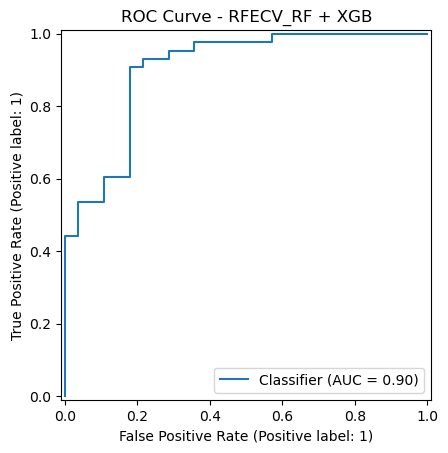

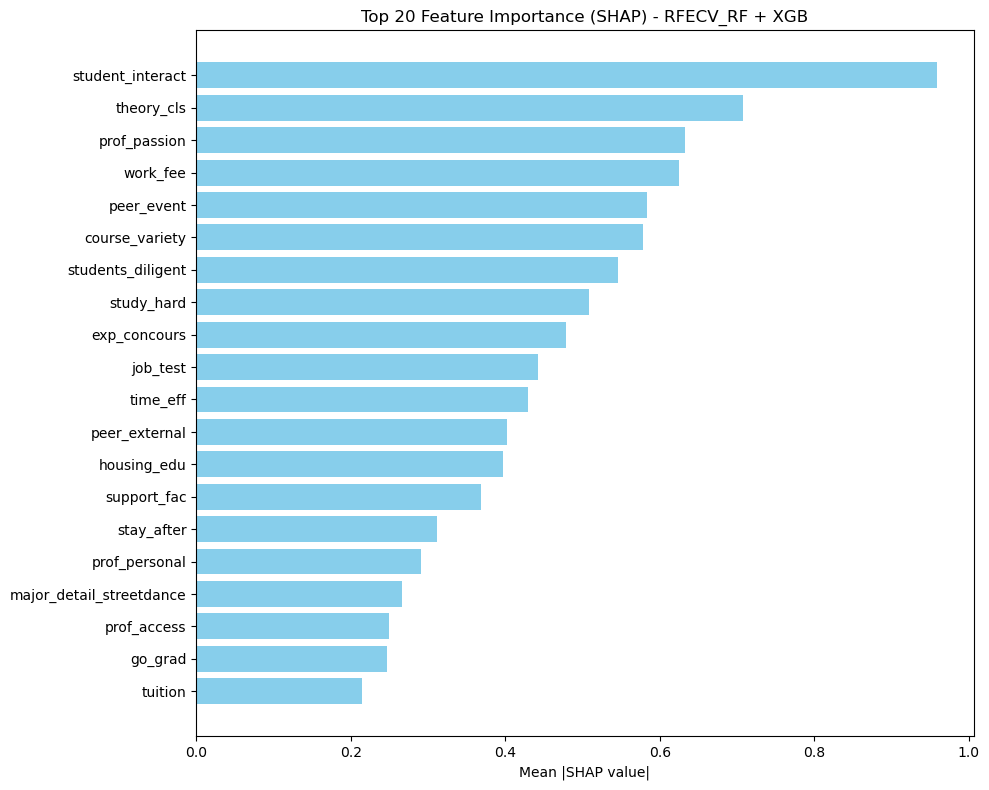

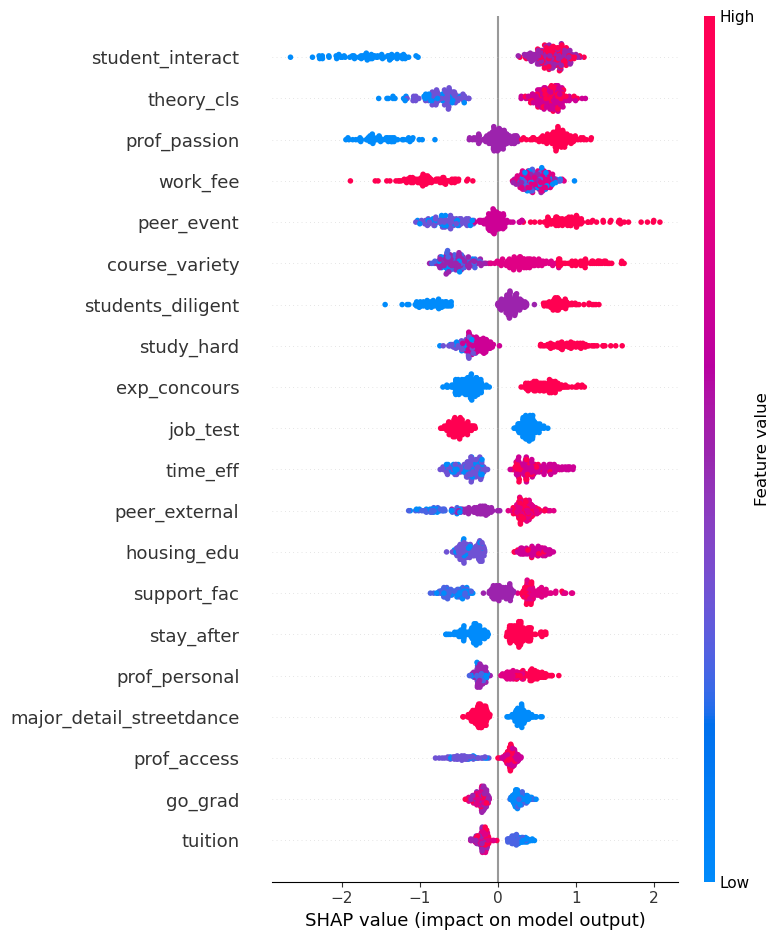

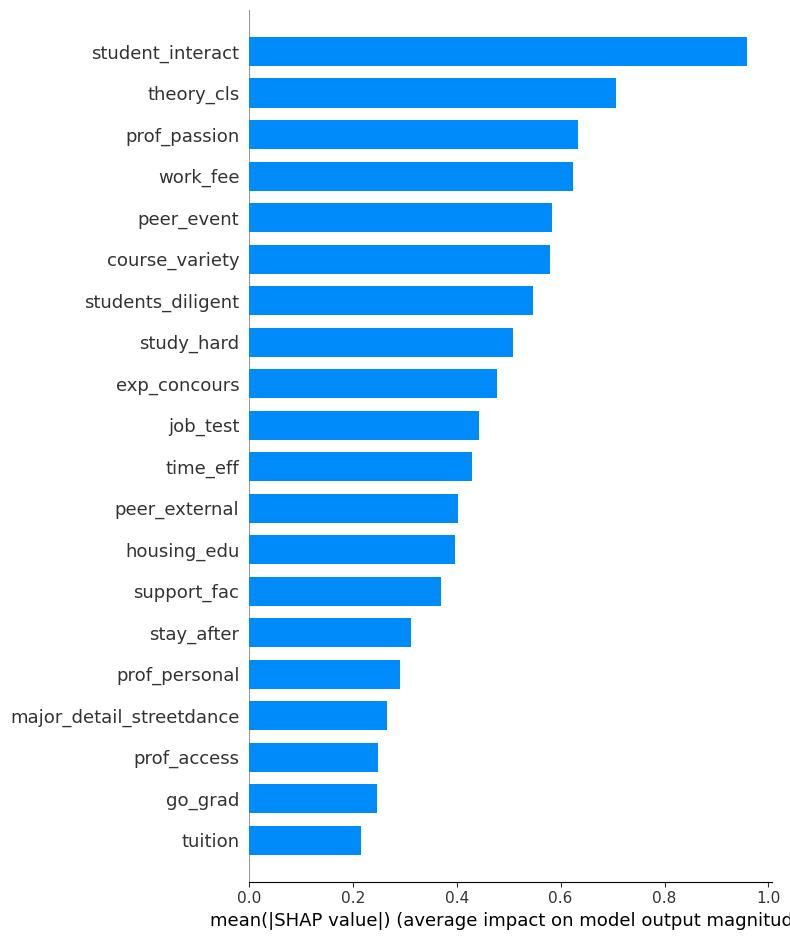

In [54]:
import matplotlib.pyplot as plt
import shap
from sklearn.metrics import RocCurveDisplay

# -------------------------
# 1) ROC Curve
# -------------------------
y_score = pipe.predict_proba(X_test[stable_vars])[:,1]  # pipe는 학습된 RFECV_RF + XGB LogReg Pipeline
RocCurveDisplay.from_predictions(y_test, y_score)
plt.title("ROC Curve - RFECV_RF + XGB")
plt.show()

import matplotlib.pyplot as plt
import shap

# -------------------------
# 1) Bar plot (SHAP 절대값 기준)
# -------------------------
plt.figure(figsize=(10,8))
top_n = 20  # 상위 N개 변수만 시각화
top_shap = shap_df.head(top_n)

plt.barh(top_shap['feature'][::-1], top_shap['shap_mean_abs'][::-1], color='skyblue')
plt.xlabel("Mean |SHAP value|")
plt.title(f"Top {top_n} Feature Importance (SHAP) - RFECV_RF + XGB")
plt.tight_layout()
plt.show()

# -------------------------
# 2) SHAP summary_dot plot
# -------------------------
# SHAP values는 explainer로 이미 계산된 shap_values 사용
# shap_values.shape = (n_samples, n_features)
# X_train_sel.columns는 feature names
shap.summary_plot(shap_values, X_train_sel, plot_type="dot", show=True)

# -------------------------
# 3) SHAP summary_bar plot
# -------------------------
shap.summary_plot(shap_values, X_train_sel, plot_type="bar", show=True)


--------------------------------